In [1]:
# %pylab nbagg
%pylab ipympl
import mpl_interactions as pli

Populating the interactive namespace from numpy and matplotlib


## For converting from electrons to photons

#### This is specific to the 225 beam collimated to this size.
1000000 initial photons:
185 made it to the phasespace file.
#### This is an efficiency of 0.000185
For this treatment we have 20 mA or 20 C/s => 20 C/s * 6.24 x 10^18 electrons/C * 20 minute treatment * 60 s/minute

In [2]:
electrons = 20*6.24E18*20*60
photons = electrons*185/1000000
print(f'number of photons, electrons {photons}, {electrons}')

number of photons, electrons 2.77056e+19, 1.4976e+23


## Topas simulation number of photons

200000 photons per angle * 180 angles

#### To get the factor to multiply the summed dose over all angles to the real dose we get a factor of how many photons we used to the total number of photons we calculated above.

In [3]:
topas_photons = 200000*180
dose_mult_factor = photons/topas_photons
print(f'The dose should be mutliplied by {dose_mult_factor} to get the real dose')

The dose should be mutliplied by 769600000000.0 to get the real dose


In [4]:
from pydicom import dcmread
import glob

In [16]:
doses = []

for file in sorted(glob.glob('./doses_neg20deg/*.dcm')):
    print(file)
    doses.append(dcmread(file).pixel_array)
#     print(np.max(dcmread(file).pixel_array))

./doses_neg20deg/dose_360_180dwells_24mmTumour_225-000.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-008.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-016.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-024.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-032.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-040.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-048.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-056.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-064.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-072.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-080.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-088.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-096.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-104.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-112.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-120.dcm
./doses_neg20deg/dose_360_180dwells_24mmTumour_225-128.d

In [17]:
fig, ax = plt.subplots()
controls = pli.hyperslicer(np.array(doses)[:,65],play_buttons=True,cmap='jet')
plt.axis('off')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.5, 227.5, 129.5, -0.5)

In [18]:
# save as a gif
anim = controls.save_animation("20neg_deg_doses.gif", fig, "axis0",interval=100, N_frames=200)

In [45]:
plt.figure()
pli.hyperslicer(np.array(doses)[:,65],play_buttons=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### The beam is being saved individually and there is a little artifact created by the voxelization of the phantom

In [46]:
myArray2 = []
fo = open("../lung_patient_nocoplanar/dylans_patient_files/EGSnrc/egs_home/dosxyznrc/lung_densities.egsphant", "r")
for line in fo:
    for nbr in line.split():
        myArray2.append(float(nbr))

In [47]:
lung_densities = np.reshape(myArray2,[228,130,115],order='f').T

In [48]:
plt.figure()
plt.imshow(lung_densities[58],cmap='gray',vmin=0.,vmax=2.19)
plt.contour(np.mean(doses,0)[58],cmap='jet',alpha=0.5)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Get a sphere for the dose normalization

#### Normalize the dose to the tumor dose

<IPython.core.display.Javascript object>


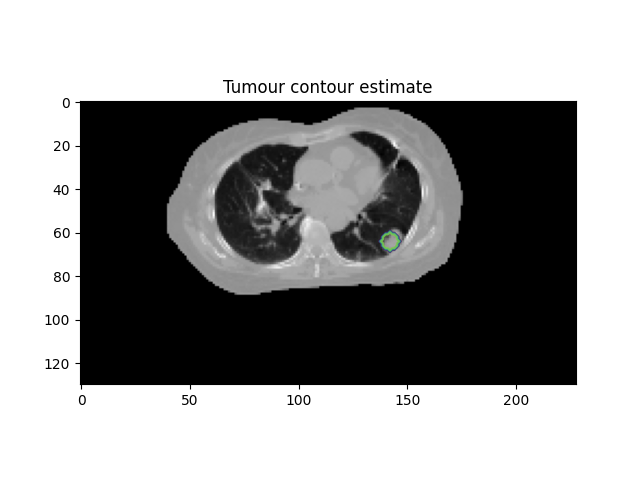

Text(0.5, 1.0, 'Tumour contour estimate')

In [12]:
mean_dose = np.mean(doses,0)[48]

def sphere(shape, radius, position):
    # assume shape and position are both a 3-tuple of int or float
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    semisizes = (radius,) * 3

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below 1
    return arr <= 1.0

sphere_bool = sphere(mean_dose.shape, 4, [64,142]) # This makes it 2.4 cm

plt.figure()
plt.imshow(lung_densities[48],cmap='gray')
plt.contour(sphere_bool,alpha=0.5)
plt.title('Tumour contour estimate')

## Plot the dose normalized to the dose in this region above 

<IPython.core.display.Javascript object>


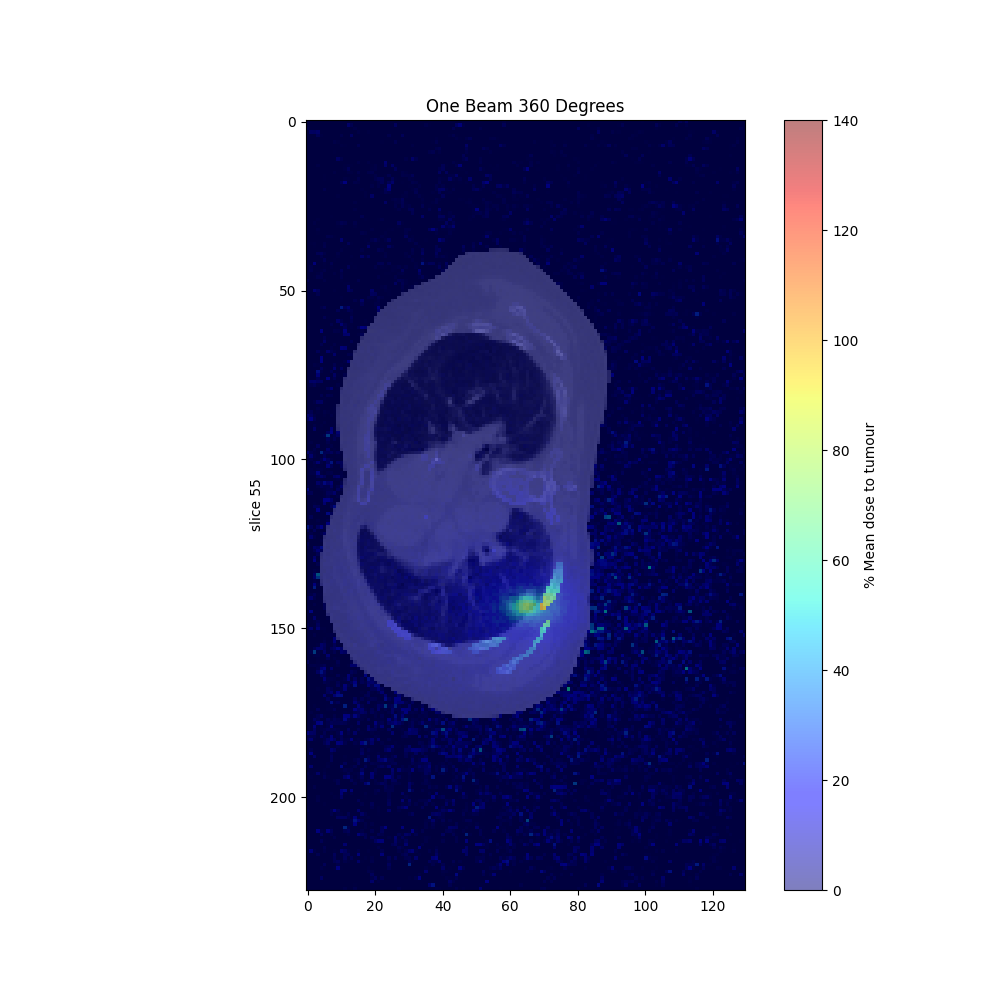

In [13]:
class IndexTracker(object):
    def __init__(self, ax, X,Y):
        self.ax = ax
        ax.set_title('One Beam 360 Degrees')

        self.X = X
        self.Y = Y
        rows, cols, self.slices = X.shape
        self.ind = 55

        self.im = ax.imshow(self.X[:, :, self.ind], cmap="gray",vmin=0.,vmax=2.19)

        self.im2 = ax.imshow(self.Y[:, :, self.ind],cmap='jet',alpha=0.5,vmin=0,vmax=140)
        plt.colorbar(self.im2,label='% Mean dose to tumour')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.im2.set_data(self.Y[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()
        self.im2.axes.figure.canvas.draw()



fig, ax = plt.subplots(1, 1,figsize=[10,10])
tracker = IndexTracker(ax,lung_densities.T, 100*np.mean(doses,0).T/np.mean(mean_dose[sphere_bool]))
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

# Now look at the addition of two non-coplanar beams

## Plot the dose normalized to the dose in this region above 

In [14]:
# Read in the 20 deg
doses_oa1 = []
for file in sorted(glob.glob('./doses_20deg/*.dcm')):
#     print(file)
    doses_oa1.append(dcmread(file,force=True).pixel_array)

# Read in the neg 20 deg
doses_oa2 = []
for file in sorted(glob.glob('./doses_neg20deg/*.dcm')):
#     print(file)
    doses_oa2.append(dcmread(file,force=True).pixel_array)

In [21]:
doses_all = np.mean([doses,doses_oa1,doses_oa2],0)

<IPython.core.display.Javascript object>


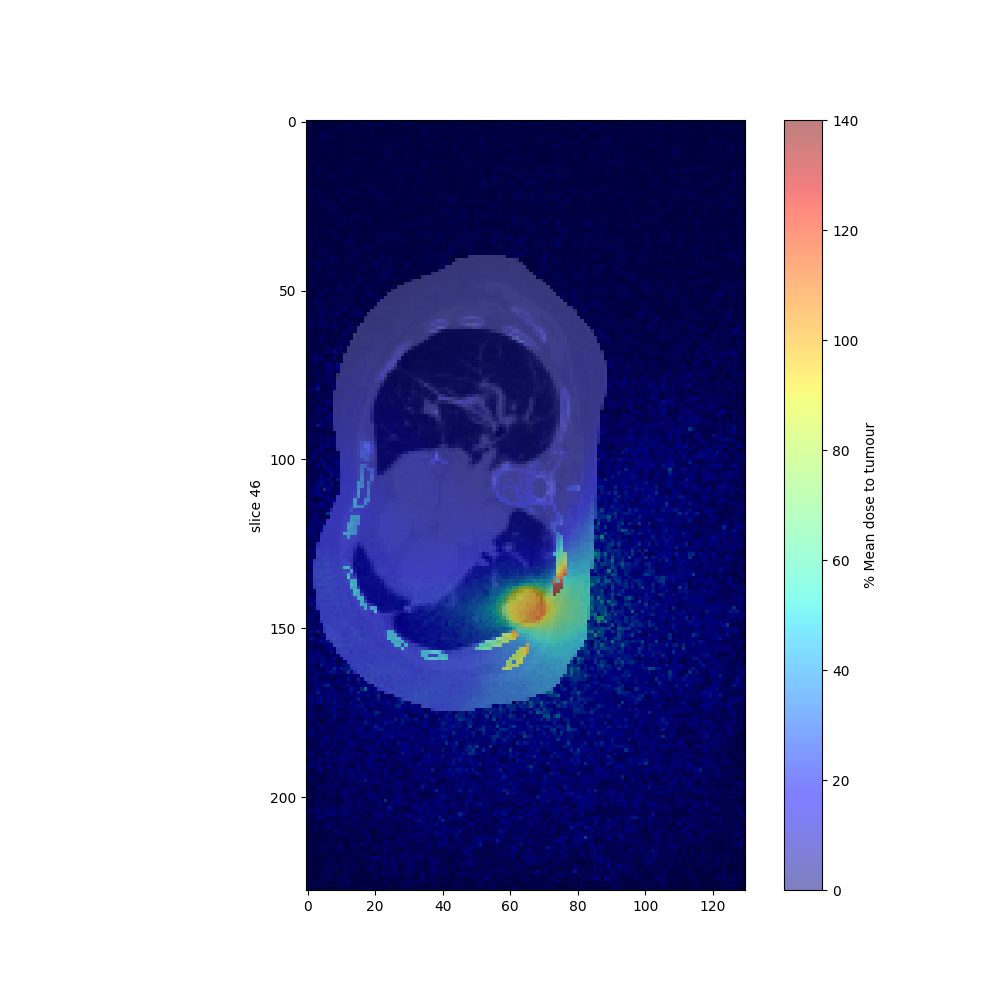

In [23]:
class IndexTracker(object):
    def __init__(self, ax, X,Y):
        self.ax = ax
        ax.set_title('')

        self.X = X
        self.Y = Y
        rows, cols, self.slices = X.shape
        self.ind = 55

        self.im = ax.imshow(self.X[:, :, self.ind], cmap="gray",vmin=0.,vmax=2.19)

        self.im2 = ax.imshow(self.Y[:, :, self.ind],cmap='jet',alpha=0.5,vmin=0,vmax=140)
        plt.colorbar(self.im2,label='% Mean dose to tumour')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.im2.set_data(self.Y[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()
        self.im2.axes.figure.canvas.draw()



fig, ax = plt.subplots(1, 1,figsize=[10,10])
tracker = IndexTracker(ax,lung_densities.T, 100*np.mean(doses_all,0).T/np.mean(np.mean(doses_all,0)[48][sphere_bool]))
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Difference between the two

<IPython.core.display.Javascript object>


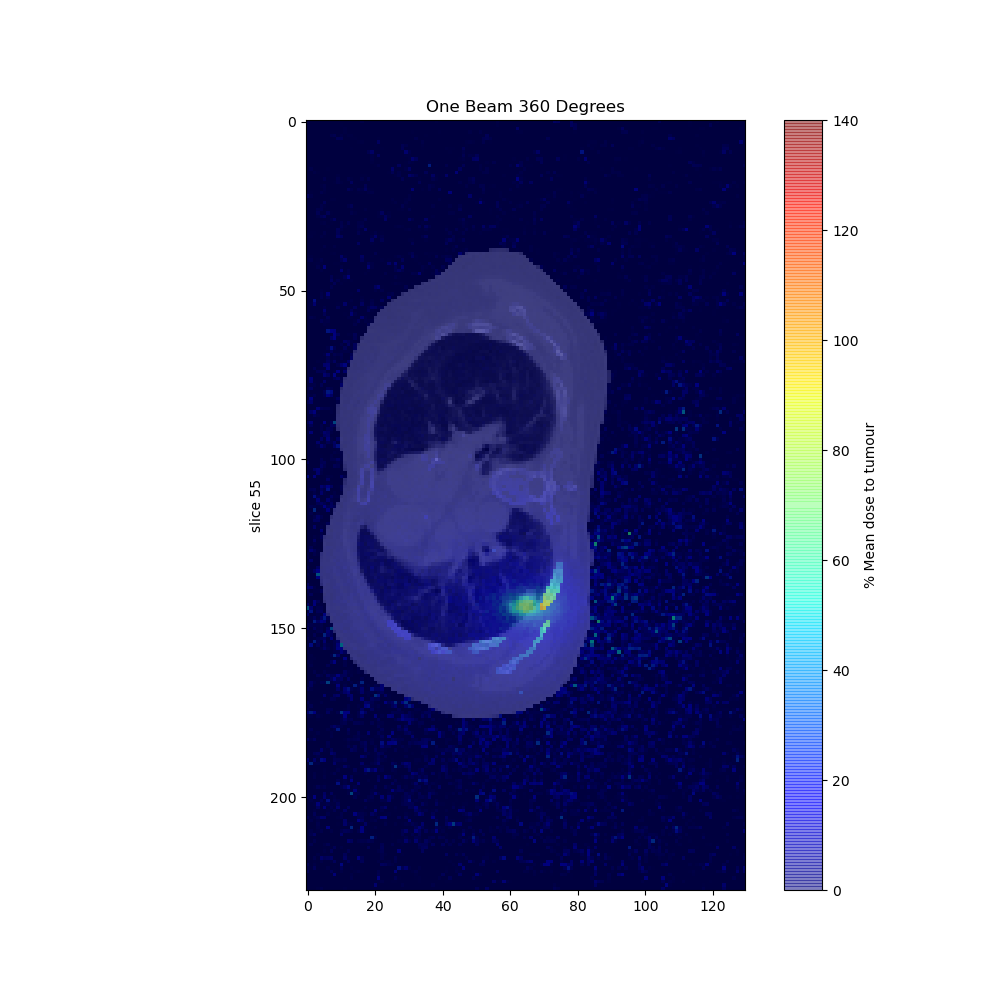

In [141]:
class IndexTracker(object):
    def __init__(self, ax, X,Y):
        self.ax = ax
        ax.set_title('One Beam 360 Degrees')

        self.X = X
        self.Y = Y
        rows, cols, self.slices = X.shape
        self.ind = 55

        self.im = ax.imshow(self.X[:, :, self.ind], cmap="gray",vmin=0.,vmax=2.19)

        self.im2 = ax.imshow(self.Y[:, :, self.ind],cmap='jet',alpha=0.5,vmin=0,vmax=140)
        plt.colorbar(self.im2,label='% Mean dose to tumour')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.im2.set_data(self.Y[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()
        self.im2.axes.figure.canvas.draw()



fig, ax = plt.subplots(1, 1,figsize=[10,10])
tracker = IndexTracker(ax,lung_densities.T, 100*(np.mean(doses_oa1,0)).T/np.mean(mean_dose[sphere_bool]))
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [144]:
np.save('lung_patient_densities',lung_densities)

In [42]:
num = 45
print(f'd:Tf/TimelineEnd                       = {num+1} ms')
print(f'i:Tf/NumberOfSequentialTimes           = {num}')
print('s:Tf/ImageName/Function      = "Step"')
print(f'sv:Tf/ImageName/Values               = {num}',end=' ')

for ii in range(0,360,int(360/num)):
    print("",end=' "')
    print("%03d" % (ii),end='"')
print()

print(f'sv:Tf/ImageName/Times               = {num}',end=' ')
for ii in range(0,num):
    print(f'{ii+1}',end=' ')
print('ms')
print()
    
print('s:Tf/angles/Function      = "Step"')
print(f'sv:Tf/angles/Values               = {num}',end=' ')

for ii in range(0,360,int(360/num)):
    print(f"{ii}",end=' ')
print('deg')

print(f'sv:Tf/angles/Times               = {num}',end=' ')
for ii in range(0,num):
    print(f"{ii+1}",end=' ')
print('ms')

d:Tf/TimelineEnd                       = 46 ms
i:Tf/NumberOfSequentialTimes           = 45
s:Tf/ImageName/Function      = "Step"
sv:Tf/ImageName/Values               = 45  "000" "008" "016" "024" "032" "040" "048" "056" "064" "072" "080" "088" "096" "104" "112" "120" "128" "136" "144" "152" "160" "168" "176" "184" "192" "200" "208" "216" "224" "232" "240" "248" "256" "264" "272" "280" "288" "296" "304" "312" "320" "328" "336" "344" "352"
sv:Tf/ImageName/Times               = 45 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 ms

s:Tf/angles/Function      = "Step"
sv:Tf/angles/Values               = 45 0 8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 deg
sv:Tf/angles/Times               = 45 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

In [35]:
0 8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352

360

In [43]:
352/8

44.0